In [2]:
import glob
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [3]:
from jinja2 import Environment, ChoiceLoader, FileSystemLoader
from IPython.display import HTML
from pandas.io.formats.style import Styler

class TabularStyler(Styler):
    env = Environment(
        loader=ChoiceLoader([
            FileSystemLoader("templates"),  # contains ours
            Styler.loader,  # the default
        ]),
        trim_blocks=True,
    )
    template_latex = env.get_template("tabularx.tpl")

In [4]:
# load the df from pickle
ue_ue_df = pd.read_pickle('df_ue-ue-multi.pkl')
ue_server_df = pd.read_pickle('df_ue-server-multi.pkl')



In [5]:
def filter_outliers(df, quantile=0.99):
    df[df["delay"] <= df.groupby("numUEs")["delay"].transform(lambda x: x.quantile(quantile))]
    df[df["delay"] >= df.groupby("numUEs")["delay"].transform(lambda x: x.quantile(1-quantile))]

    return df

# filter out the outliers 99th percentile
ue_ue_df = filter_outliers(ue_ue_df)
ue_server_df = filter_outliers(ue_server_df)

ue_ue_df["delay"] = ue_ue_df["delay"] * 1000
ue_server_df["delay"] = ue_server_df["delay"] * 1000

# ue_ue_df["delay"] = ue_ue_df["delay"].astype(np.uint32)
# ue_server_df["delay"] = ue_server_df["delay"].astype(np.uint32)


ue_ue_df["numUEs"] = ue_ue_df["numUEs"].astype(np.uint8)
ue_server_df["numUEs"] = ue_server_df["numUEs"].astype(np.uint8)


In [33]:
desc_ue = ue_ue_df.groupby('numUEs')['delay'].describe()
# add the 99th percentile to the table
desc_ue['99th perc. ($ms$)'] = ue_ue_df.groupby('numUEs')['delay'].quantile(0.99) 
desc_ue = desc_ue.drop(columns=['count', '25%', '50%', '75%', 'min'])
desc_ue.rename(columns={'mean': 'Mean ($ms$)', 'std': 'Std ($ms$)', 'max': 'Max ($ms$)'}, inplace=True)
desc_ue = desc_ue[['Mean ($ms$)', 'Std ($ms$)', '99th perc. ($ms$)', 'Max ($ms$)']]
desc_ue.index.names = ['\# UEs']
display(desc_ue)




Mean ($ms$)   Std ($ms$)  99th perc. ($ms$)     Max ($ms$)
\# UEs                                                            
9         14.496841     2.246581          20.753137      37.342478
18        14.155935     1.537714          20.591061      34.781493
27        15.451377     3.491975          28.934123     120.014537
36        23.024628    12.527250          71.807696    1026.890399
45        31.245048    21.612821         116.160980     619.597846
54        40.120938    32.322808         168.002805     735.839657
63        47.426340    43.136389         218.154327    1065.755562
72        55.114139    53.394464         270.468556    1360.166184
81        64.431670    69.839861         342.387180    1666.355756
90        73.714403    85.303610         419.058955    2192.864559
99        85.560306   115.243248         540.950402    3162.724686
108      102.505517   182.767694         775.101768    5308.708415
117      116.327892   238.882248         907.336035    8929.117527
126      139.784979   385.675881        1250.707627   12325.026874
135      210.310405   870.670128        3717.088824   19661.480254
144      292.177943  1713.872975        4759.493154   34756.766597
153      868.813045  7845.042989        9677.767903  136336.572367

In [27]:
desc_ue.index

UInt64Index([9, 18, 27, 36, 45, 54, 63, 72, 81, 90, 99, 108, 117, 126, 135,
             144, 153],
            dtype='uint64', name='\# UEs')

In [41]:

tab_path = '/home/alberto/Jobs/Papers/work_in_progress/IEC61850_AMPS_2023/tables'

desc_ue_styled = desc_ue.style.apply(lambda x: ['background-color: #d3d3d3' if x.name == 36 else '' for i in x], axis=1)

# Display the styled DataFrame
display(desc_ue_styled)

#s = TabularStyler(desc_ue_styled)
desc_ue_styled.format('{:.2f}')
desc_ue_styled.to_latex(os.path.join(tab_path, 'table_multi_ues.tex'), hrules=True, column_format='lrrrr', multicol_align='|c|', convert_css=True)

In [6]:
desc_ue = ue_ue_df.groupby('numUEs')['delay'].describe()
desc_ue = desc_ue.drop(columns=['count', '25%', '50%', '75%', 'min', 'max'])
desc_ue.rename(columns={'mean': 'Mean ($ms$)', 'std': 'Std ($ms$)'}, inplace=True)
desc_ue = pd.concat([desc_ue], keys=["E2E"], names=["Scenario"], axis=1)

desc_server = ue_server_df.groupby('numUEs')['delay'].describe()
desc_server = desc_server.drop(columns=['count', '25%', '50%', '75%', 'min', 'max'])
desc_server.rename(columns={'mean': 'Mean ($ms$)', 'std': 'Std ($ms$)'}, inplace=True)
desc_server = pd.concat([desc_server], keys=["E2S"], names=["Scenario"], axis=1)

# merge horizontally
desc = pd.concat([desc_ue, desc_server], axis=1)
display(desc)


s = TabularStyler(desc)
s.format('{:.2f}')
s.to_latex('table.tex', hrules=True, clines="all;data", column_format='lrrrr', multicol_align='|c|')

Scenario         E2E                      E2S           
         Mean ($ms$)   Std ($ms$) Mean ($ms$) Std ($ms$)
numUEs                                                  
9          14.496841     2.246581    9.386167   2.327825
18         14.155935     1.537714    8.713812   1.216559
27         15.451377     3.491975    8.718657   1.200316
36         23.024628    12.527250    9.054858   1.842973
45         31.245048    21.612821    8.804290   1.393979
54         40.120938    32.322808    8.964137   1.736555
63         47.426340    43.136389    9.149595   2.173758
72         55.114139    53.394464    8.975755   1.757043
81         64.431670    69.839861    9.215243   2.198564
90         73.714403    85.303610    9.366616   3.041669
99         85.560306   115.243248    9.447182   3.435574
108       102.505517   182.767694    9.138581   2.063266
117       116.327892   238.882248    9.292344   2.336671
126       139.784979   385.675881    9.304402   2.570040
135       210.310405   870.670128    9.330985   2.399034
144       292.177943  1713.872975    9.200585   2.184903
153       868.813045  7845.042989    9.327843   4.796938

In [7]:
merged_df = pd.concat([ue_ue_df, ue_server_df])



In [9]:
aa = merged_df.groupby(["numUEs", "scenario"]).describe()
display(aa)


delay                                      \
                            count        mean          std        min   
numUEs scenario                                                         
9      ue-server-multi   259458.0    9.386167     2.327825   6.739965   
       ue-ue-multi       233132.0   14.496841     2.246581   9.077635   
18     ue-server-multi   517537.0    8.713812     1.216559   4.012402   
       ue-ue-multi       488973.0   14.155935     1.537714  10.918192   
27     ue-server-multi   783990.0    8.718657     1.200316   4.615002   
       ue-ue-multi       754254.0   15.451377     3.491975  11.070638   
36     ue-server-multi  1042792.0    9.054858     1.842973   4.192049   
       ue-ue-multi      1003478.0   23.024628    12.527250  11.358170   
45     ue-server-multi  1299962.0    8.804290     1.393979   4.855315   
       ue-ue-multi      1264232.0   31.245048    21.612821  13.000000   
54     ue-server-multi  1563589.0    8.964137     1.736555   4.805773   
       ue-ue-multi      1526858.0   40.120938    32.322808  13.000000   
63     ue-server-multi  1818706.0    9.149595     2.173758   4.079319   
       ue-ue-multi      1785988.0   47.426340    43.136389  10.720170   
72     ue-server-multi  2092296.0    8.975755     1.757043   4.037386   
       ue-ue-multi      2044381.0   55.114139    53.394464  13.000000   
81     ue-server-multi  2348387.0    9.215243     2.198564   4.222632   
       ue-ue-multi      2320261.0   64.431670    69.839861  13.000000   
90     ue-server-multi  2605773.0    9.366616     3.041669   4.133915   
       ue-ue-multi      2574979.0   73.714403    85.303610  13.000000   
99     ue-server-multi  2861695.0    9.447182     3.435574   4.284287   
       ue-ue-multi      2827004.0   85.560306   115.243248  13.000000   
108    ue-server-multi  3132251.0    9.138581     2.063266   4.169557   
       ue-ue-multi      3090606.0  102.505517   182.767694  13.000000   
117    ue-server-multi  3377367.0    9.292344     2.336671   4.155350   
       ue-ue-multi      3344466.0  116.327892   238.882248  13.000000   
126    ue-server-multi  3642312.0    9.304402     2.570040   4.181699   
       ue-ue-multi      3614341.0  139.784979   385.675881  13.000000   
135    ue-server-multi  3908020.0    9.330985     2.399034   4.629031   
       ue-ue-multi      3874254.0  210.310405   870.670128   9.338230   
144    ue-server-multi  4168243.0    9.200585     2.184903   4.183504   
       ue-ue-multi      4116108.0  292.177943  1713.872975  13.000000   
153    ue-server-multi  4413431.0    9.327843     4.796938   4.001066   
       ue-ue-multi      4380813.0  868.813045  7845.042989  13.000000   

                                                                         
                              25%        50%         75%            max  
numUEs scenario                                                          
9      ue-server-multi   8.307602   8.582770    8.871496      38.882693  
       ue-ue-multi      13.315440  13.653422   13.965255      37.342478  
18     ue-server-multi   8.254625   8.512057    8.771274      26.989100  
       ue-ue-multi      13.363503  13.700815   14.263166      34.781493  
27     ue-server-multi   8.254275   8.515744    8.778258      26.772225  
       ue-ue-multi      13.545801  14.226365   15.956168     120.014537  
36     ue-server-multi   8.281082   8.554167    8.824068      32.869794  
       ue-ue-multi      15.162750  19.265386   26.081125    1026.890399  
45     ue-server-multi   8.261393   8.532812    8.794471      26.975523  
       ue-ue-multi      17.787551  24.541145   36.743223     619.597846  
54     ue-server-multi   8.265190   8.540989    8.809487      32.648413  
       ue-ue-multi      20.320887  30.118977   48.076980     735.839657  
63     ue-server-multi   8.283390   8.552749    8.830532     308.831295  
       ue-ue-multi      21.949555  34.175975   56.924617    1065.755562  
72     ue-server-multi   8.268390   8.533588    8.805609      26.978

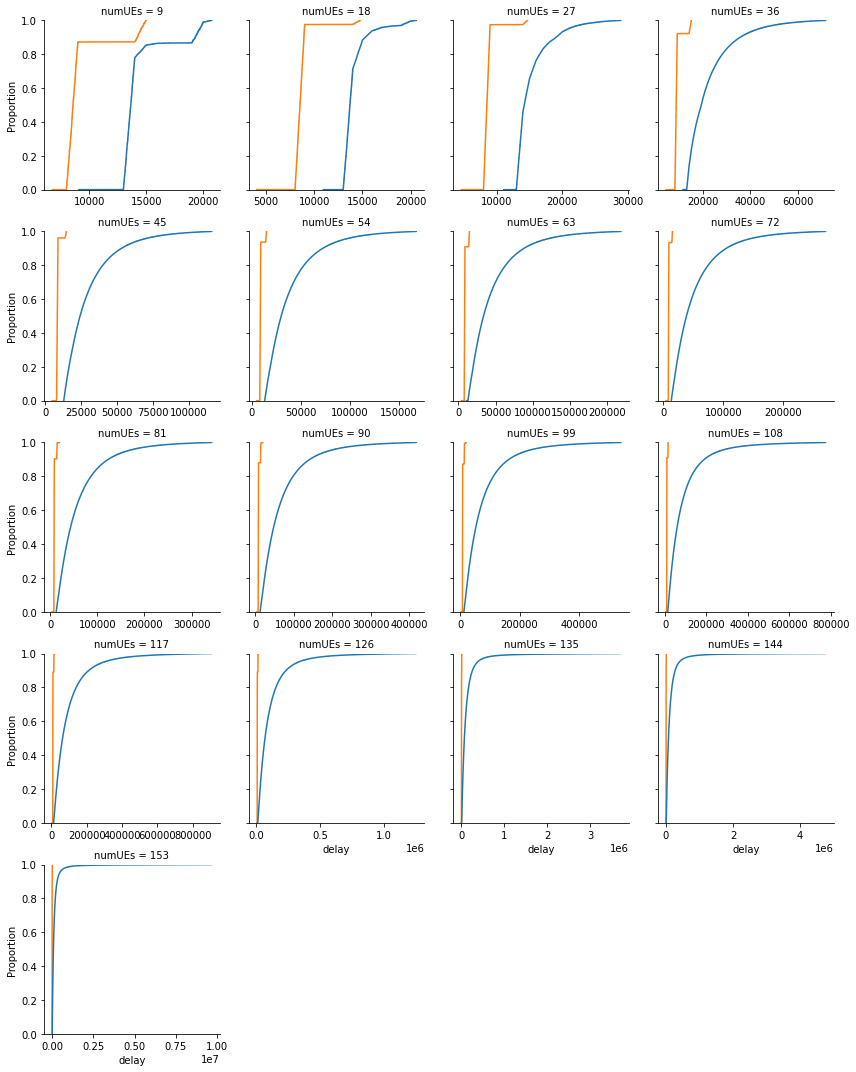

In [ ]:
g = sns.FacetGrid(merged_df, col="numUEs", col_wrap=4, sharex=False)
g.map_dataframe(sns.ecdfplot, x="delay", hue="scenario")

plt.show()

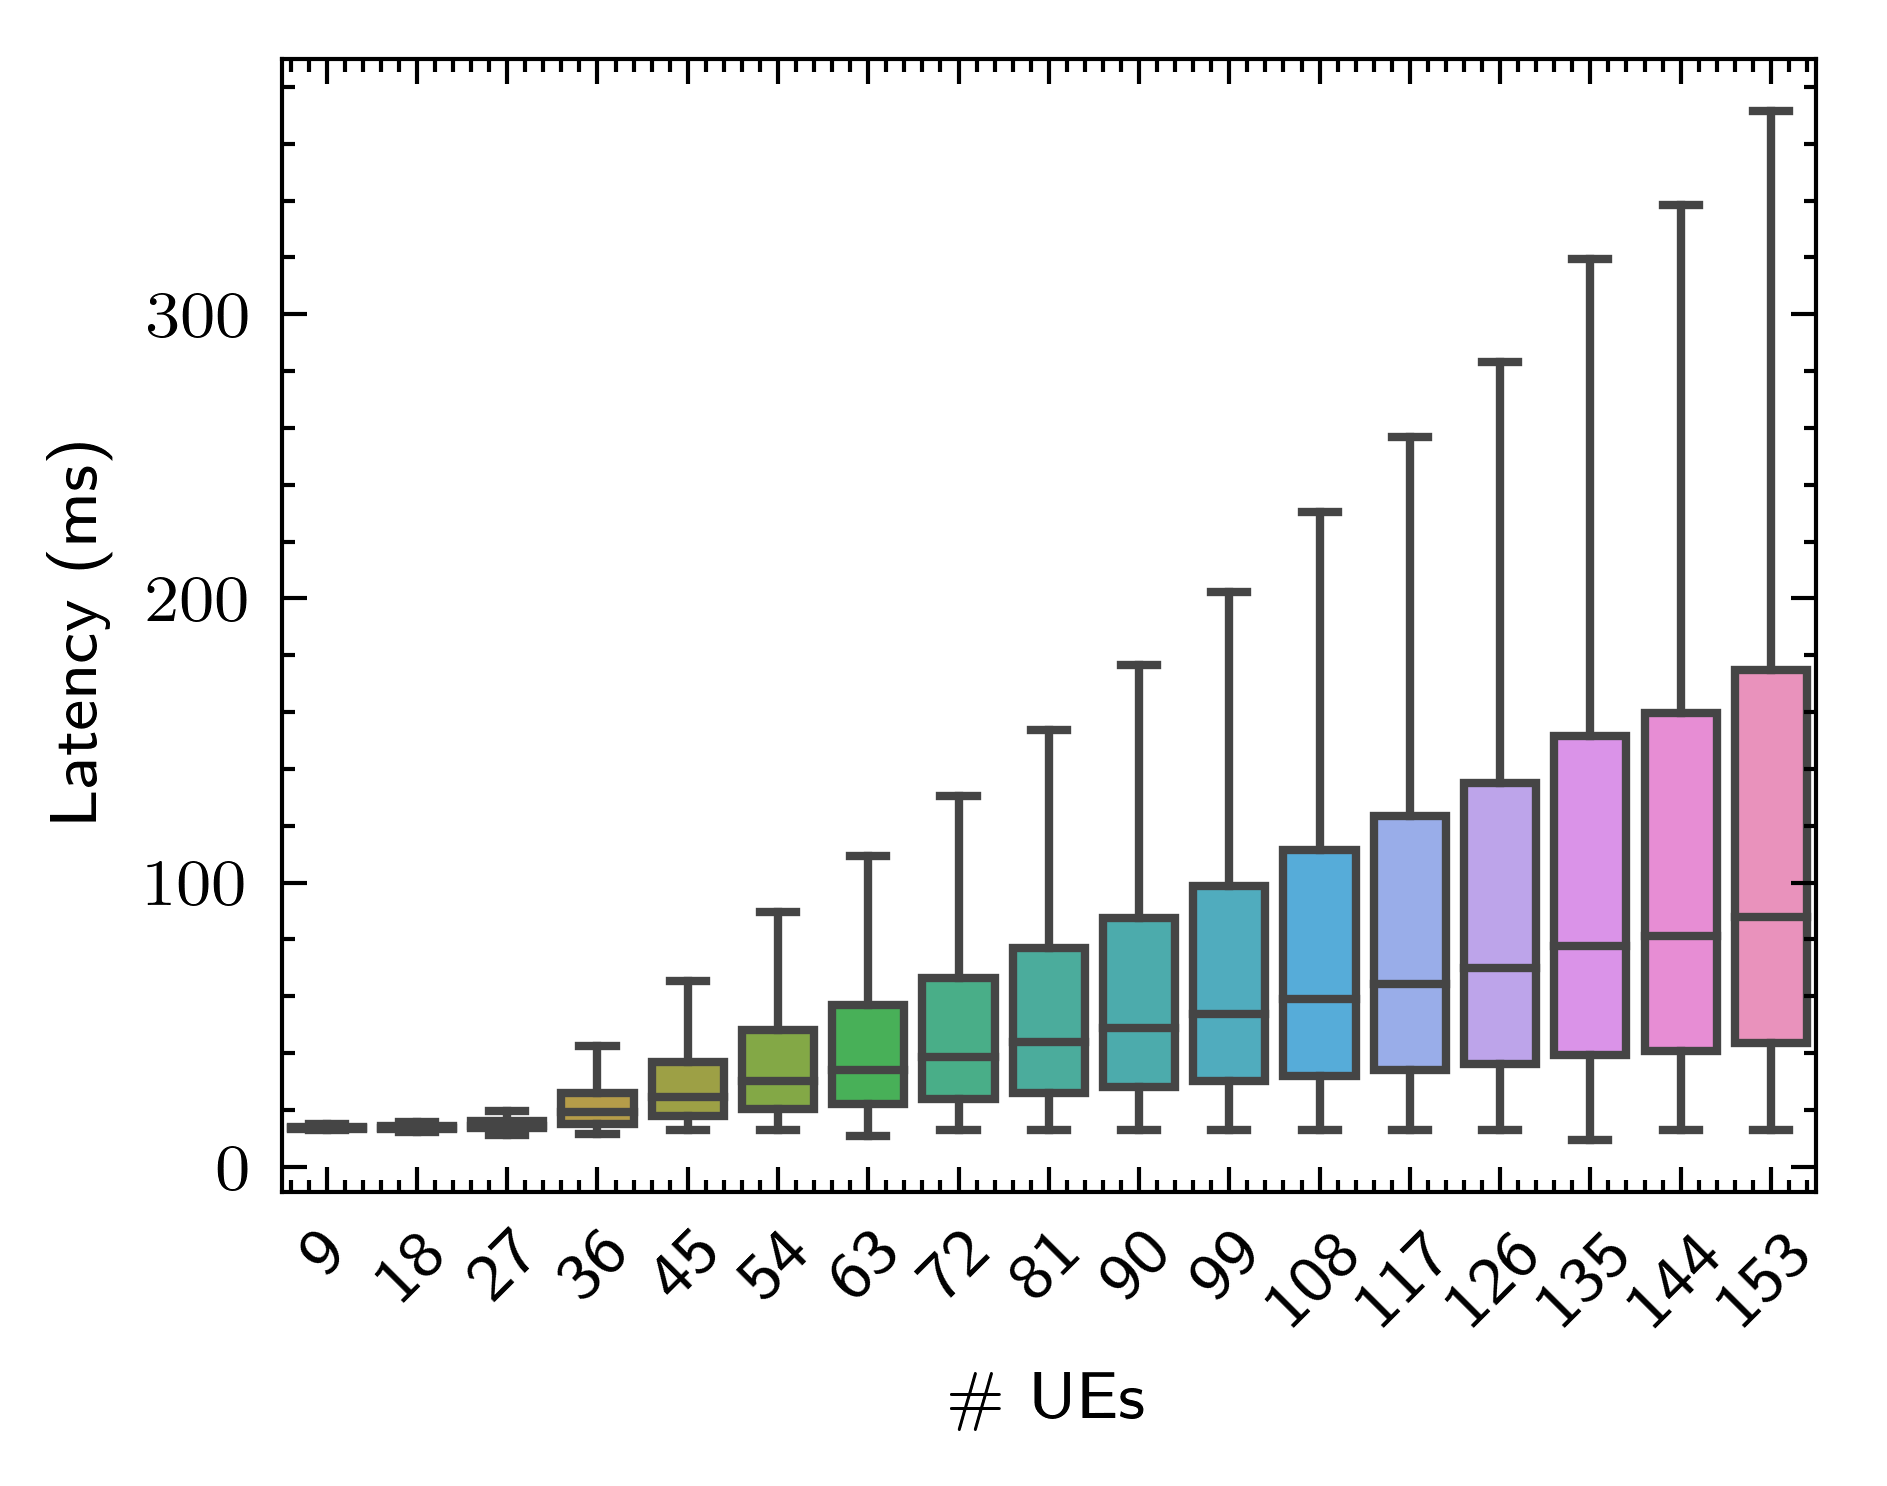

In [14]:


fig_path = '/home/alberto/Jobs/Papers/work_in_progress/IEC61850_AMPS_2023/Images'
plot_style = ['./science_frame_on_small_legend.mplstyle', './ieee.mplstyle']
with plt.style.context(plot_style):
    g = sns.boxplot(x="numUEs", y="delay", data=ue_ue_df, showfliers = False)
    g.set(ylabel='Latency (ms)', xlabel='\# UEs')
    plt.xticks(rotation=45)
    plt.savefig(os.path.join(fig_path, 'gnb_multi_eus.pdf'), bbox_inches='tight')


delay  numUEs     scenario
6       13000      18  ue-ue-multi
7       15000      18  ue-ue-multi
10      16000      18  ue-ue-multi
12      20000      18  ue-ue-multi
13      13000      18  ue-ue-multi
...       ...     ...          ...
488968  13751      18  ue-ue-multi
488969  13751      18  ue-ue-multi
488970  13751      18  ue-ue-multi
488971  13751      18  ue-ue-multi
488972  13751      18  ue-ue-multi

[484088 rows x 3 columns]

<AxesSubplot:xlabel='delay', ylabel='numUEs'>

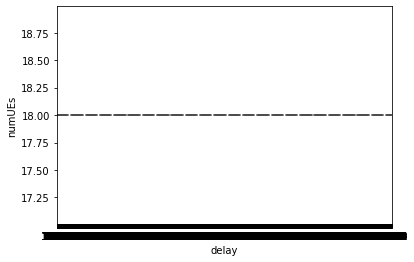

In [ ]:
aa = ue_ue_df[(ue_ue_df["numUEs"] == 18)]
display(aa)
sns.violinplot(data=aa, x="delay", y="numUEs")

22


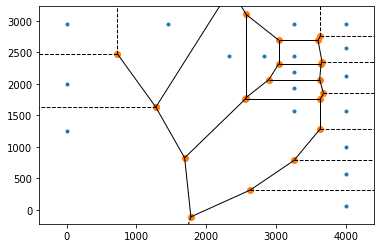

In [ ]:
points = np.array([[10, 2950 - 1697.5],
          [10, 2950 - 947.5],
          [10, 2950 - 10],
          [1447.5, 2950 - 10],
          [3260, 2950 - 10],
          [4010, 2950 - 10],
          [4010, 2950 - 385],
          [4010, 2950 - 822.5],
          [4010, 2950 - 1385],
          [4010, 2950 - 1947.5],
          [4010, 2950 - 2385],
          [4010, 2950 - 2885],
          [3260, 2950 - 510],
          [2822.5, 2950 - 510],
          [2322.5, 2950 - 510],
          [3260, 2950 - 760],
          [3260, 2950 - 1010],
          [3260, 2950 - 1385]])

from scipy.spatial import Voronoi, voronoi_plot_2d
vor = Voronoi(points)

print(len(vor.vertices))

import matplotlib.pyplot as plt
fig = voronoi_plot_2d(vor)
plt.show()




In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(points)

kmeans.cluster_centers_


array([[3347.5  , 2358.75 ],
       [ 728.75 , 2940.   ],
       [4010.   ,  799.375],
       [  10.   , 1627.5  ]])

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
X = np.array([[1, 2], [1, 4], [1, 0],
              [10, 2], [10, 4], [10, 0]])
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(X)
kmeans.labels_

kmeans.predict([[0, 0], [12, 3]])

kmeans.cluster_centers_

array([[10.,  2.],
       [ 1.,  2.]])